In [98]:
import os
from cmath import rect, phase
from math import radians, degrees
import functools
import operator
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from pandas import DataFrame, Series
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

#import scikitplot
#from scikitplot.metrics import plot_roc_curve as prc
#from scikitplot.metrics import plot_lift_curve as plc
#from scikitplot.metrics import plot_cumulative_gain as pcg
#from sklearn.metrics import classification_report

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

In [28]:
path = 'C:/Users/quent/OneDrive/Documents/GitHub/projet-ia/'

general = pd.read_csv(path + "general_data.csv")
employe = pd.read_csv(path + "employee_survey_data.csv")
manager = pd.read_csv(path + "manager_survey_data.csv")
In = pd.read_csv(path + "in_time.csv")
Out = pd.read_csv(path + "out_time.csv")

On remplace les "NaN" en 0 dans les tables In et Out, représentant les nombres de congés des employés. On vérifie ensuite que le nombre de congés dans les tables soient correct

In [29]:
In.fillna(0, inplace=True)
Out.fillna(0, inplace=True)
vac_In = (In == 0).astype(int).sum(axis=1)
vac_Out = (Out ==0).astype(int).sum(axis=1)
 
vac_In.equals(vac_Out)

True

On fait ensuite un graphe pour voir les jours de congés dans leur globalité 

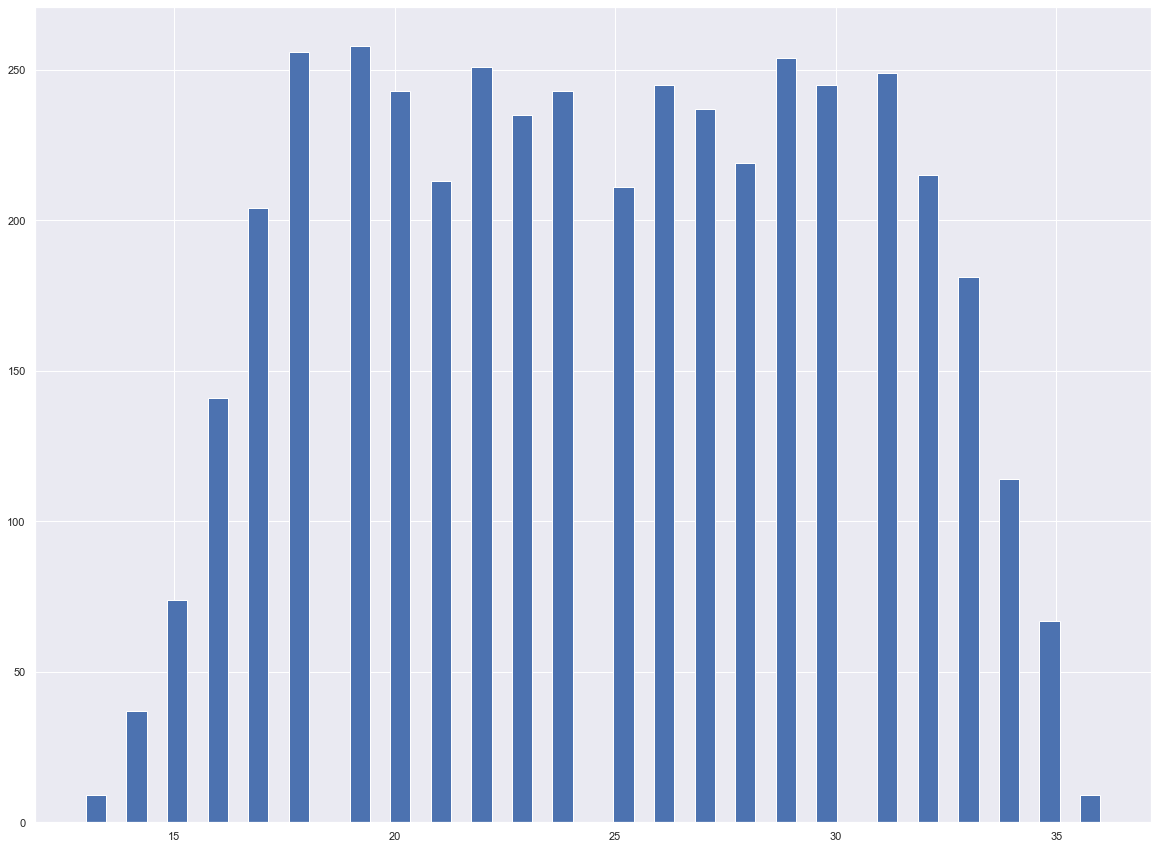

In [30]:
vac_In.hist(bins=50, figsize=(20,15))
plt.show()

On supprimes la première colonne des deux tableaux car elles ne sont pas utiles.

In [31]:
In = In.drop(In.columns[0], axis = 1)
Out = Out.drop(Out.columns[0], axis = 1)

On transforme les donnés des deux tables en format datetime pour pouvoir calculer plus facilement l'heure moyenne d'entrée et de sortie des employées

In [32]:
In_h = In.iloc[:, 0:262].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S' )
Out_h = Out.iloc[:, 0:262].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S' )

Nous réalisons à travers une fonction, le calcule de l'heure moyenne d'entré et de sortie de chaque employé :

In [33]:
def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mean_time(row):
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) 
               for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
Out_h['AverageInTime'] = Out_h.apply(mean_time, axis=1)

In [34]:
In_h['AverageInTime'].head()

0    10:00:05
1    09:59:17
2    10:01:30
3    09:58:54
4    09:59:54
Name: AverageInTime, dtype: object

Ensuite on calcule l'heure en moyen de travail en soustraitant la moyen de départ à la moyen d'arrivée grâce à Timedelta

In [35]:
Average_Out = pd.to_timedelta(Out_h['AverageInTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = Average_Out - Average_In

print(AverageTimeWorking)

0      07:22:25
1      07:43:08
2      07:00:47
3      07:11:37
4      08:00:21
         ...   
4405   08:31:20
4406   06:05:34
4407   07:42:24
4408   09:29:34
4409   06:59:20
Name: AverageInTime, Length: 4410, dtype: timedelta64[ns]


Il ne nous reste plus qu'a ajouter le nombre de vacances et l'heure de travail moyenne de chaque employés pour étudier leur cas tout en combinant les autres tableaux ensembles.

On fusionne les trois tableaux CSV pour regrouper les données :

In [44]:
combined = general.merge(manager, how='right', on = 'EmployeeID')
combined_csv = combined.merge(employe, how='right', on = 'EmployeeID')
#On transforme tous les NA en 0
combined_csv.fillna(0, inplace=True)
combined_csv['AverageTimeWorking'] = AverageTimeWorking
combined_csv['Holidays'] = vac_In

combined_csv


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3,3,3.0,4.0,2.0,07:22:25,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,4,3.0,2.0,4.0,07:43:08,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,3,2.0,2.0,1.0,07:00:47,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,2,3,4.0,4.0,3.0,07:11:37,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,3,3,4.0,1.0,3.0,08:00:21,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,3,3,4.0,1.0,3.0,08:31:20,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,2,3,4.0,4.0,3.0,06:05:34,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,3,4,1.0,3.0,3.0,07:42:24,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,2,3,4.0,1.0,3.0,09:29:34,20


In [43]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [39]:
combined_csv.isnull().sum()

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
AverageTimeWorking         0
Holidays                   0
dtype: int64

Nous avons l'heure moyenne de travail par employé mais le format tiemdelta64 ça vous causer problème. Ils font donc le modifier

In [45]:
Time_float = combined_csv['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageTimeWorking'] = Time_float

0       7.373611
1       7.718889
2       7.013056
3       7.193611
4       8.005833
          ...   
4405    8.522222
4406    6.092778
4407    7.706667
4408    9.492778
4409    6.988889
Name: AverageTimeWorking, Length: 4410, dtype: float64


In [52]:
combined_csv.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16


In [47]:
combined_csv['Attrition'].value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

In [51]:
combined_csv['EmployeeCount'].value_counts()

KeyError: 'EmployeeCount'

Ils sont tous à 1 donc osef

Après concertation, nous avons décidé de supprimer les données Over18 et EmployeeCount. 

In [53]:
combined_csv = combined_csv.drop(columns=['EmployeeCount','Over18'])

KeyError: "['EmployeeCount' 'Over18'] not found in axis"

Attrition : yes -> l'employé est parti en 2016 / no -> il est toujours dans l'entreprise

In [54]:
combined_csv['Attrition'].value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

On cherche à savoir pourquoi ces 711 employés ont quitté l'entreprise, nous allons donc uniquement nous concentrer sur les données où l'Attrition est 'yes'.

Pour commencer notre étude, nous allons nous interesser uniquement aux données liées aux employés qui ont quitté la structure, c'est-à-dire dont l'Attrition est 'yes'.

In [55]:
combinedLeft = combined_csv.drop(combined_csv[combined_csv.Attrition == 'No'].index).copy()
combinedLeft

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,Male,2,...,0,0,0,3,4,1.0,3.0,1.0,6.923611,29
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,Male,1,...,10,9,9,2,3,1.0,2.0,2.0,9.400000,26
28,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,Male,2,...,1,0,0,2,3,4.0,3.0,1.0,10.977778,18
30,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,Male,3,...,3,0,2,2,3,1.0,2.0,3.0,10.109444,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,Female,1,...,4,0,1,3,4,3.0,4.0,2.0,8.406667,22
4386,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,Male,1,...,5,0,4,2,4,3.0,4.0,1.0,10.915278,28
4388,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,Male,2,...,9,1,7,3,3,1.0,1.0,4.0,7.096944,31
4391,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,Male,3,...,3,1,2,3,3,4.0,3.0,1.0,10.176389,21


In [56]:
combinedStay = combined_csv.drop(combined_csv[combined_csv.Attrition == 'Yes'].index).copy()
combinedStay

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,6,Female,4,...,7,7,7,3,3,3.0,2.0,2.0,10.796111,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


## Étude des employés partis (Attrition = Yes)

Afin de pouvoir étudier d'éventuelles corrélations, nous allons, dans un DataFrame temporaire, numériser certaines valeurs afin de n'avoir que des valeurs numériques.

In [57]:
combinedLeft['BusinessTravel'].value_counts()

Travel_Rarely        468
Travel_Frequently    207
Non-Travel            36
Name: BusinessTravel, dtype: int64

In [58]:
combinedLeft['Department'].value_counts()

Research & Development    453
Sales                     201
Human Resources            57
Name: Department, dtype: int64

In [59]:
combinedLeft['EducationField'].value_counts()

Life Sciences       303
Medical             225
Marketing            75
Technical Degree     45
Human Resources      33
Other                30
Name: EducationField, dtype: int64

In [60]:
combinedLeft['JobRole'].value_counts()

Sales Executive              165
Research Scientist           159
Laboratory Technician        126
Research Director             57
Healthcare Representative     57
Manufacturing Director        48
Manager                       42
Sales Representative          36
Human Resources               21
Name: JobRole, dtype: int64

In [61]:
combinedLeft['Gender'].value_counts()

Male      441
Female    270
Name: Gender, dtype: int64

In [62]:
combinedLeft['MaritalStatus'].value_counts()

Single      360
Married     252
Divorced     99
Name: MaritalStatus, dtype: int64

On initialise la copie du DataFrame.

In [63]:
combinedLeftNum = combinedLeft.copy()
combinedLeftNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,Male,2,...,0,0,0,3,4,1.0,3.0,1.0,6.923611,29
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,Male,1,...,10,9,9,2,3,1.0,2.0,2.0,9.400000,26
28,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,Male,2,...,1,0,0,2,3,4.0,3.0,1.0,10.977778,18
30,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,Male,3,...,3,0,2,2,3,1.0,2.0,3.0,10.109444,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,Female,1,...,4,0,1,3,4,3.0,4.0,2.0,8.406667,22
4386,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,Male,1,...,5,0,4,2,4,3.0,4.0,1.0,10.915278,28
4388,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,Male,2,...,9,1,7,3,3,1.0,1.0,4.0,7.096944,31
4391,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,Male,3,...,3,1,2,3,3,4.0,3.0,1.0,10.176389,21


On reset l'index qui s'est retrouvé sans certains indices suite à notre supression de certaines données.

In [64]:
combinedLeftNum.reset_index(drop=True, inplace=True)
combinedLeftNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
1,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,Male,2,...,0,0,0,3,4,1.0,3.0,1.0,6.923611,29
2,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,Male,1,...,10,9,9,2,3,1.0,2.0,2.0,9.400000,26
3,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,Male,2,...,1,0,0,2,3,4.0,3.0,1.0,10.977778,18
4,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,Male,3,...,3,0,2,2,3,1.0,2.0,3.0,10.109444,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,Female,1,...,4,0,1,3,4,3.0,4.0,2.0,8.406667,22
707,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,Male,1,...,5,0,4,2,4,3.0,4.0,1.0,10.915278,28
708,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,Male,2,...,9,1,7,3,3,1.0,1.0,4.0,7.096944,31
709,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,Male,3,...,3,1,2,3,3,4.0,3.0,1.0,10.176389,21


Pour chaque donnée, on affecte une valeur numérique.

In [65]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['BusinessTravel'][i] == 'Non-Travel':
        combinedLeftNum['BusinessTravel'][i] = 0
    elif combinedLeftNum['BusinessTravel'][i] == 'Travel_Rarely':
        combinedLeftNum['BusinessTravel'][i] = 1
    elif combinedLeftNum['BusinessTravel'][i] == 'Travel_Frequently':
        combinedLeftNum['BusinessTravel'][i] = 2

In [66]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['Department'][i] == 'Human Resources':
        combinedLeftNum['Department'][i] = 0
    elif combinedLeftNum['Department'][i] == 'Sales':
        combinedLeftNum['Department'][i] = 1
    elif combinedLeftNum['Department'][i] == 'Research & Development':
        combinedLeftNum['Department'][i] = 2

In [67]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['EducationField'][i] == 'Other':
        combinedLeftNum['EducationField'][i] = 0
    elif combinedLeftNum['EducationField'][i] == 'Human Resources':
        combinedLeftNum['EducationField'][i] = 1
    elif combinedLeftNum['EducationField'][i] == 'Technical Degree':
        combinedLeftNum['EducationField'][i] = 2
    elif combinedLeftNum['EducationField'][i] == 'Marketing':
        combinedLeftNum['EducationField'][i] = 3
    elif combinedLeftNum['EducationField'][i] == 'Medical':
        combinedLeftNum['EducationField'][i] = 4
    elif combinedLeftNum['EducationField'][i] == 'Life Sciences':
        combinedLeftNum['EducationField'][i] = 5

In [68]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['JobRole'][i] == 'Human Resources':
        combinedLeftNum['JobRole'][i] = 0
    elif combinedLeftNum['JobRole'][i] == 'Sales Representative':
        combinedLeftNum['JobRole'][i] = 1
    elif combinedLeftNum['JobRole'][i] == 'Manager':
        combinedLeftNum['JobRole'][i] = 2
    elif combinedLeftNum['JobRole'][i] == 'Manufacturing Director':
        combinedLeftNum['JobRole'][i] = 3
    elif combinedLeftNum['JobRole'][i] == 'Healthcare Representative':
        combinedLeftNum['JobRole'][i] = 4
    elif combinedLeftNum['JobRole'][i] == 'Research Director':
        combinedLeftNum['JobRole'][i] = 5
    elif combinedLeftNum['JobRole'][i] == 'Laboratory Technician':
        combinedLeftNum['JobRole'][i] = 6
    elif combinedLeftNum['JobRole'][i] == 'Research Scientist':
        combinedLeftNum['JobRole'][i] = 7
    elif combinedLeftNum['JobRole'][i] == 'Sales Executive':
        combinedLeftNum['JobRole'][i] = 8

In [69]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['Gender'][i] == 'Male':
        combinedLeftNum['Gender'][i] = 0
    elif combinedLeftNum['Gender'][i] == 'Female':
        combinedLeftNum['Gender'][i] = 1

In [70]:
for i in range (0, combinedLeftNum.shape[0]):
    if combinedLeftNum['MaritalStatus'][i] == 'Single':
        combinedLeftNum['MaritalStatus'][i] = 0
    elif combinedLeftNum['MaritalStatus'][i] == 'Married':
        combinedLeftNum['MaritalStatus'][i] = 1
    elif combinedLeftNum['MaritalStatus'][i] == 'Divorced':
        combinedLeftNum['MaritalStatus'][i] = 2

On vérifie que tout a bien été numérisé.

In [71]:
combinedLeftNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,31,Yes,2,2,10,1,5,2,1,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
1,28,Yes,1,2,11,2,4,7,0,2,...,0,0,0,3,4,1.0,3.0,1.0,6.923611,29
2,47,Yes,0,2,1,1,4,14,0,1,...,10,9,9,2,3,1.0,2.0,2.0,9.400000,26
3,44,Yes,2,2,1,2,4,29,0,2,...,1,0,0,2,3,4.0,3.0,1.0,10.977778,18
4,26,Yes,1,2,4,3,4,31,0,3,...,3,0,2,2,3,1.0,2.0,3.0,10.109444,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,Yes,1,2,7,1,5,4382,1,1,...,4,0,1,3,4,3.0,4.0,2.0,8.406667,22
707,33,Yes,1,1,11,4,3,4387,0,1,...,5,0,4,2,4,3.0,4.0,1.0,10.915278,28
708,33,Yes,1,1,1,3,5,4389,0,2,...,9,1,7,3,3,1.0,1.0,4.0,7.096944,31
709,32,Yes,1,1,23,1,5,4392,0,3,...,3,1,2,3,3,4.0,3.0,1.0,10.176389,21


In [72]:
# Les valeures numériques changées précédemment sont considérées comme des objets et non des valeures numériques
# On utilise to_numeric afin de changer cela et de pouvoir les visulaiser dans des tableaux/graphes.
combinedLeftNum['BusinessTravel']=pd.to_numeric(combinedLeftNum['BusinessTravel'])
combinedLeftNum['Department']=pd.to_numeric(combinedLeftNum['Department'])
combinedLeftNum['EducationField']=pd.to_numeric(combinedLeftNum['EducationField'])
combinedLeftNum['JobRole']=pd.to_numeric(combinedLeftNum['JobRole'])
combinedLeftNum['Gender']=pd.to_numeric(combinedLeftNum['Gender'])
combinedLeftNum['MaritalStatus']=pd.to_numeric(combinedLeftNum['MaritalStatus'])
print(combinedLeftNum.dtypes)

Age                          int64
Attrition                   object
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField               int64
EmployeeID                   int64
Gender                       int64
JobLevel                     int64
JobRole                      int64
MaritalStatus                int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
AverageTimeWorking         float64
Holidays            

Nous allons ensuite utiliser ces données numérisées afin de construire un tableau de corrélation, afin de voir si certaines données semblent plus ou moins correlées entre elles.

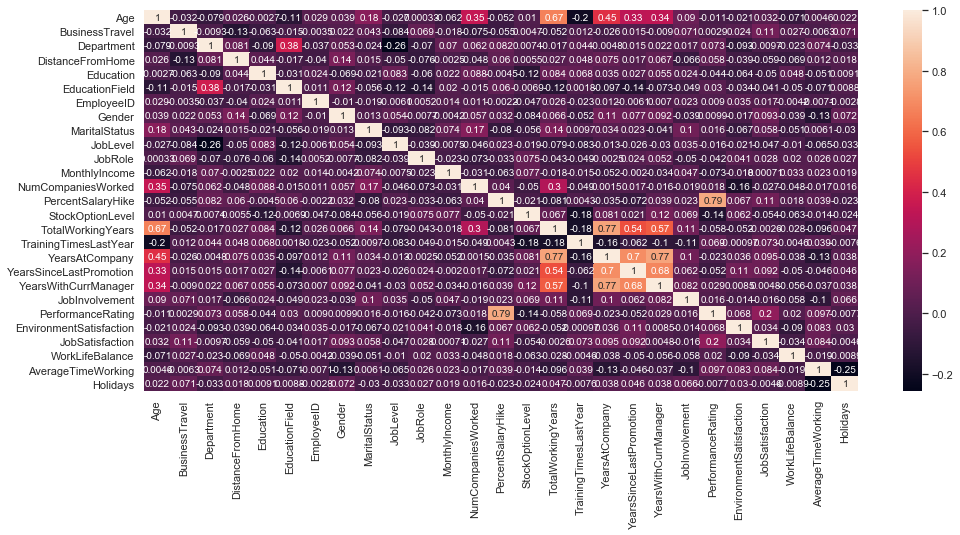

In [73]:
corr_cols = combinedLeftNum[['Age','BusinessTravel','Department','DistanceFromHome',
                     'Education','EducationField','EmployeeID', 'Gender', 'MaritalStatus',
                      'JobLevel',
                     'JobRole','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                     'StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
                     'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager',
                     'JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                     'JobSatisfaction','WorkLifeBalance','AverageTimeWorking','Holidays']]
corr = corr_cols.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr, annot=True)
plt.show()

Nous pouvons constater que certaines données semblent liées fortement, notamment ce qui tourne autour de l'expérience de l'employé (Age, TotalWorkingYears, YearsAtCompany,YearsSinceLastPromotion, YearsWithCurrManager). On note également un lien entre le PerformanceRating et le PercentSalaryHike.

Faisons quelques graphes afin de voir si quoi que ce soit est notable visuellement.

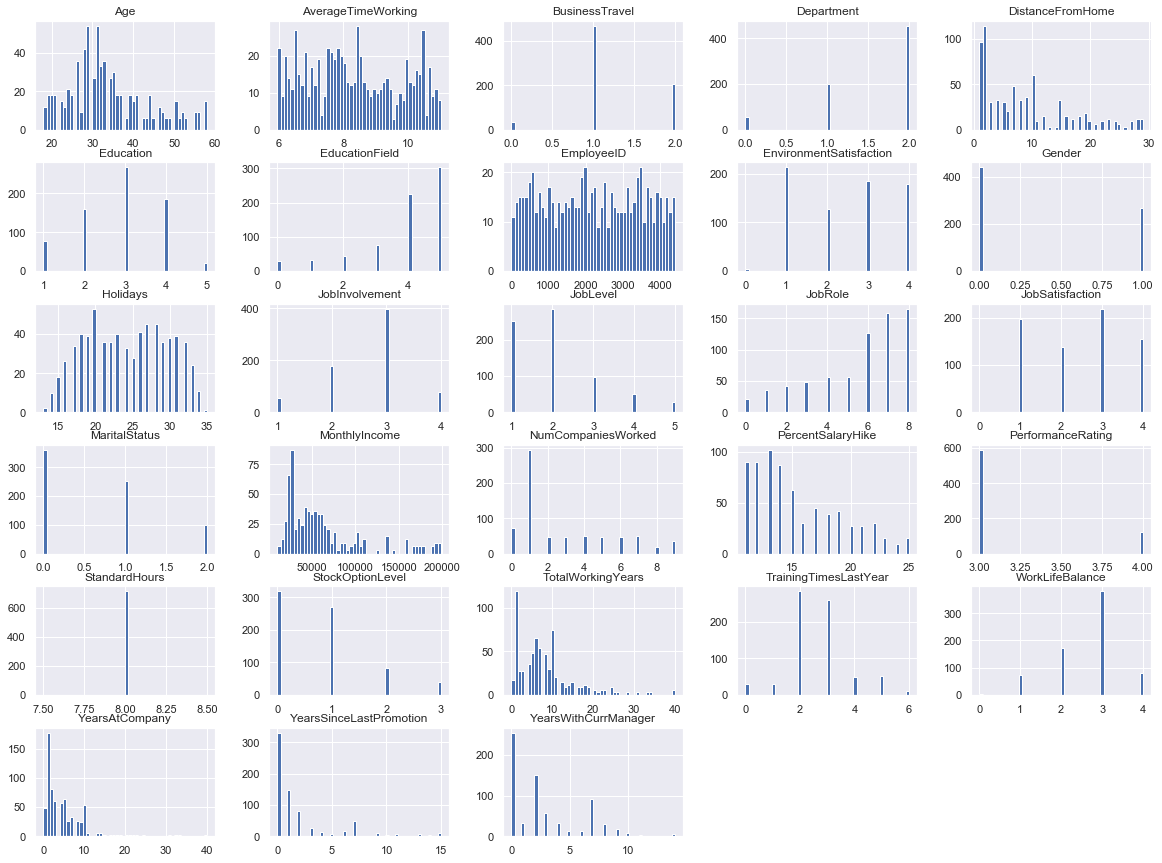

In [74]:
combinedLeftNum.hist(bins=50, figsize=(20,15))
plt.show()

In [75]:
combinedLeft['Department'].value_counts()

Research & Development    453
Sales                     201
Human Resources            57
Name: Department, dtype: int64

In [76]:
combinedLeftRes = combinedLeft[combinedLeft.Department == 'Research & Development'].copy()
combinedLeftRes

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,Male,2,...,0,0,0,3,4,1.0,3.0,1.0,6.923611,29
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,Male,1,...,10,9,9,2,3,1.0,2.0,2.0,9.400000,26
28,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,Male,2,...,1,0,0,2,3,4.0,3.0,1.0,10.977778,18
30,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,Male,3,...,3,0,2,2,3,1.0,2.0,3.0,10.109444,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4344,35,Yes,Travel_Rarely,Research & Development,2,4,Life Sciences,4345,Female,2,...,1,0,1,4,3,2.0,3.0,3.0,8.998333,19
4362,32,Yes,Travel_Rarely,Research & Development,5,3,Medical,4363,Male,1,...,14,9,8,4,3,4.0,4.0,2.0,7.797222,31
4366,30,Yes,Travel_Rarely,Research & Development,10,4,Life Sciences,4367,Female,2,...,5,0,4,2,3,4.0,1.0,3.0,8.493333,28
4369,29,Yes,Travel_Rarely,Research & Development,2,3,Life Sciences,4370,Male,1,...,6,1,5,2,3,3.0,3.0,2.0,7.816944,23


In [77]:
combinedLeftSales = combinedLeft[combinedLeft.Department == 'Sales'].copy()
combinedLeftSales

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
124,26,Yes,Travel_Frequently,Sales,14,3,Life Sciences,125,Male,2,...,6,0,4,3,3,3.0,0.0,3.0,6.999167,21
127,30,Yes,Travel_Frequently,Sales,3,2,Marketing,128,Male,3,...,1,0,0,2,3,3.0,4.0,3.0,8.191667,21
178,33,Yes,Travel_Rarely,Sales,5,4,Marketing,179,Male,2,...,4,1,3,3,4,1.0,4.0,3.0,6.965000,17
182,34,Yes,Travel_Frequently,Sales,17,1,Marketing,183,Male,1,...,3,0,2,4,4,2.0,1.0,3.0,10.995556,24
205,26,Yes,Travel_Rarely,Sales,1,3,Marketing,206,Female,2,...,1,0,0,1,4,3.0,4.0,1.0,8.751389,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4368,30,Yes,Travel_Frequently,Sales,3,2,Medical,4369,Male,2,...,6,0,1,2,3,3.0,1.0,2.0,6.992500,31
4386,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,Male,1,...,5,0,4,2,4,3.0,4.0,1.0,10.915278,28
4388,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,Male,2,...,9,1,7,3,3,1.0,1.0,4.0,7.096944,31
4391,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,Male,3,...,3,1,2,3,3,4.0,3.0,1.0,10.176389,21


In [78]:
combinedLeftHR = combinedLeft[combinedLeft.Department == 'Human Resources'].copy()
combinedLeftHR

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
105,33,Yes,Travel_Rarely,Human Resources,28,2,Human Resources,106,Female,5,...,1,0,0,1,4,4.0,3.0,3.0,10.509444,30
112,21,Yes,Travel_Rarely,Human Resources,10,2,Human Resources,113,Male,1,...,1,0,0,3,3,3.0,2.0,3.0,5.995278,31
310,55,Yes,Travel_Rarely,Human Resources,7,3,Human Resources,311,Male,4,...,5,1,4,3,3,4.0,1.0,3.0,7.978611,22
350,55,Yes,Travel_Rarely,Human Resources,16,3,Technical Degree,351,Male,4,...,9,7,3,4,3,3.0,4.0,2.0,6.376389,33
453,29,Yes,Travel_Rarely,Human Resources,3,5,Life Sciences,454,Male,1,...,0,0,0,2,3,4.0,1.0,3.0,10.280833,25
538,25,Yes,Travel_Rarely,Human Resources,25,4,Human Resources,539,Female,2,...,7,5,6,2,3,4.0,4.0,4.0,10.900278,21
599,44,Yes,Travel_Rarely,Human Resources,6,2,Human Resources,600,Male,3,...,6,0,2,1,3,3.0,3.0,3.0,10.402500,30
613,24,Yes,Travel_Rarely,Human Resources,28,4,Human Resources,614,Male,3,...,1,0,0,3,3,4.0,2.0,1.0,6.562222,34
655,45,Yes,Travel_Rarely,Human Resources,12,3,Human Resources,656,Male,2,...,24,1,11,3,3,1.0,2.0,3.0,9.878889,30
878,28,Yes,Travel_Rarely,Human Resources,1,3,Medical,879,Female,2,...,1,0,0,3,3,3.0,2.0,3.0,8.417222,24


Le nombre de départs d'employés travaillant aux Ressources Humaines ne représentant que 8.02% des départs, nous faisons le choix de les ignorer pour le moment.

## Étude des départs depuis le département R&D

### Comparaison en fonction du JobRole

Nous allons tenter de voir s'il y a une possible corrélation entre les départs liés au département R&D et le métier dans l'entreprise des employés.

In [79]:
combinedLeftRes['JobRole'].value_counts()

Sales Executive              111
Research Scientist            99
Laboratory Technician         72
Research Director             42
Manufacturing Director        36
Sales Representative          30
Manager                       24
Healthcare Representative     21
Human Resources               18
Name: JobRole, dtype: int64

24.5% des départs de ce département viennent des personnes travaillant en tant que Sales Executive.
Les départs des Research Scientists représentent à eux 21.9% des départs.

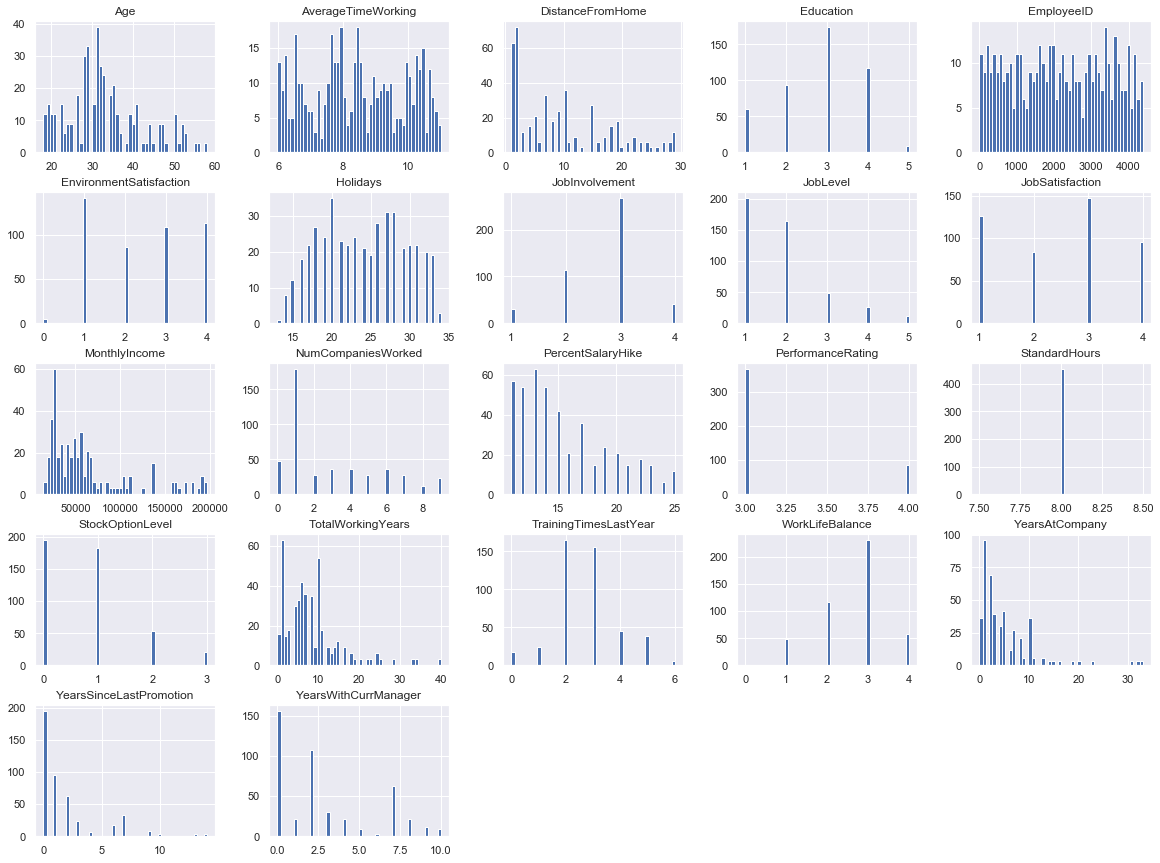

In [80]:
combinedLeftRes.hist(bins=50, figsize=(20,15))
plt.show()

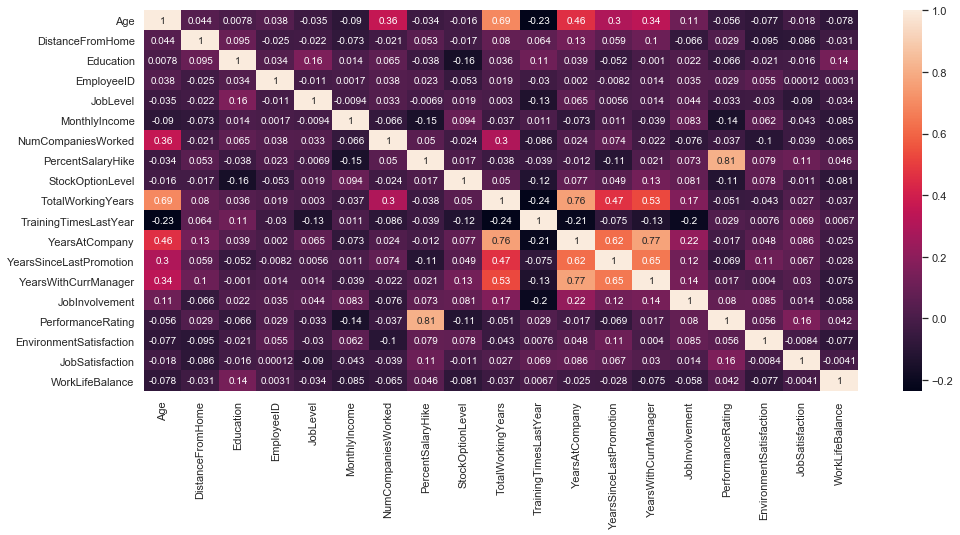

In [81]:
corr_cols = combinedLeftRes[['Age','BusinessTravel','Department','DistanceFromHome',
                     'Education','EducationField','EmployeeID', 'Gender', 'MaritalStatus',
                      'JobLevel',
                     'JobRole','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                     'StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
                     'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager',
                     'JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                     'JobSatisfaction','WorkLifeBalance']]
corr = corr_cols.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr, annot=True)
plt.show()

# Étude des employés restés (Attrition = No)

Nous allons effectuer à nouveau les mêmes démarches qu'avec l'autre groupe.

In [82]:
combinedStayNum = combinedStay.copy()
combinedStayNum.reset_index(drop=True, inplace=True)
combinedStayNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
2,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
3,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
4,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,6,Female,4,...,7,7,7,3,3,3.0,2.0,2.0,10.796111,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
3695,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
3696,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
3697,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


In [83]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['BusinessTravel'][i] == 'Non-Travel':
        combinedStayNum['BusinessTravel'][i] = 0
    elif combinedStayNum['BusinessTravel'][i] == 'Travel_Rarely':
        combinedStayNum['BusinessTravel'][i] = 1
    elif combinedStayNum['BusinessTravel'][i] == 'Travel_Frequently':
        combinedStayNum['BusinessTravel'][i] = 2

In [84]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['Department'][i] == 'Human Resources':
        combinedStayNum['Department'][i] = 0
    elif combinedStayNum['Department'][i] == 'Sales':
        combinedStayNum['Department'][i] = 1
    elif combinedStayNum['Department'][i] == 'Research & Development':
        combinedStayNum['Department'][i] = 2

In [85]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['EducationField'][i] == 'Other':
        combinedStayNum['EducationField'][i] = 0
    elif combinedStayNum['EducationField'][i] == 'Human Resources':
        combinedStayNum['EducationField'][i] = 1
    elif combinedStayNum['EducationField'][i] == 'Technical Degree':
        combinedStayNum['EducationField'][i] = 2
    elif combinedStayNum['EducationField'][i] == 'Marketing':
        combinedStayNum['EducationField'][i] = 3
    elif combinedStayNum['EducationField'][i] == 'Medical':
        combinedStayNum['EducationField'][i] = 4
    elif combinedStayNum['EducationField'][i] == 'Life Sciences':
        combinedStayNum['EducationField'][i] = 5

In [86]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['JobRole'][i] == 'Human Resources':
        combinedStayNum['JobRole'][i] = 0
    elif combinedStayNum['JobRole'][i] == 'Sales Representative':
        combinedStayNum['JobRole'][i] = 1
    elif combinedStayNum['JobRole'][i] == 'Manager':
        combinedStayNum['JobRole'][i] = 2
    elif combinedStayNum['JobRole'][i] == 'Manufacturing Director':
        combinedStayNum['JobRole'][i] = 3
    elif combinedStayNum['JobRole'][i] == 'Healthcare Representative':
        combinedStayNum['JobRole'][i] = 4
    elif combinedStayNum['JobRole'][i] == 'Research Director':
        combinedStayNum['JobRole'][i] = 5
    elif combinedStayNum['JobRole'][i] == 'Laboratory Technician':
        combinedStayNum['JobRole'][i] = 6
    elif combinedStayNum['JobRole'][i] == 'Research Scientist':
        combinedStayNum['JobRole'][i] = 7
    elif combinedStayNum['JobRole'][i] == 'Sales Executive':
        combinedStayNum['JobRole'][i] = 8

In [87]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['Gender'][i] == 'Male':
        combinedStayNum['Gender'][i] = 0
    elif combinedStayNum['Gender'][i] == 'Female':
        combinedStayNum['Gender'][i] = 1

In [88]:
for i in range (0, combinedStayNum.shape[0]):
    if combinedStayNum['MaritalStatus'][i] == 'Single':
        combinedStayNum['MaritalStatus'][i] = 0
    elif combinedStayNum['MaritalStatus'][i] == 'Married':
        combinedStayNum['MaritalStatus'][i] = 1
    elif combinedStayNum['MaritalStatus'][i] == 'Divorced':
        combinedStayNum['MaritalStatus'][i] = 2

In [89]:
combinedStayNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,1,1,6,2,5,1,1,1,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,32,No,2,2,17,4,0,3,0,4,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
2,38,No,0,2,2,5,5,4,0,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
3,32,No,1,2,10,1,4,5,0,1,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
4,46,No,1,2,8,3,5,6,1,4,...,7,7,7,3,3,3.0,2.0,2.0,10.796111,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,42,No,1,2,5,4,4,4406,1,1,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
3695,29,No,1,2,2,4,4,4407,0,1,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
3696,25,No,1,2,25,2,5,4408,0,2,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
3697,42,No,1,1,18,2,4,4409,0,1,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


In [90]:
# Les valeures numériques changées précédemment sont considérées comme des objets et non des valeures numériques
# On utilise to_numeric afin de changer cela et de pouvoir les visulaiser dans des tableaux/graphes.
combinedStayNum['BusinessTravel']=pd.to_numeric(combinedStayNum['BusinessTravel'])
combinedStayNum['Department']=pd.to_numeric(combinedStayNum['Department'])
combinedStayNum['EducationField']=pd.to_numeric(combinedStayNum['EducationField'])
combinedStayNum['JobRole']=pd.to_numeric(combinedStayNum['JobRole'])
combinedStayNum['Gender']=pd.to_numeric(combinedStayNum['Gender'])
combinedStayNum['MaritalStatus']=pd.to_numeric(combinedStayNum['MaritalStatus'])
print(combinedStayNum.dtypes)

Age                          int64
Attrition                   object
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField               int64
EmployeeID                   int64
Gender                       int64
JobLevel                     int64
JobRole                      int64
MaritalStatus                int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
AverageTimeWorking         float64
Holidays            

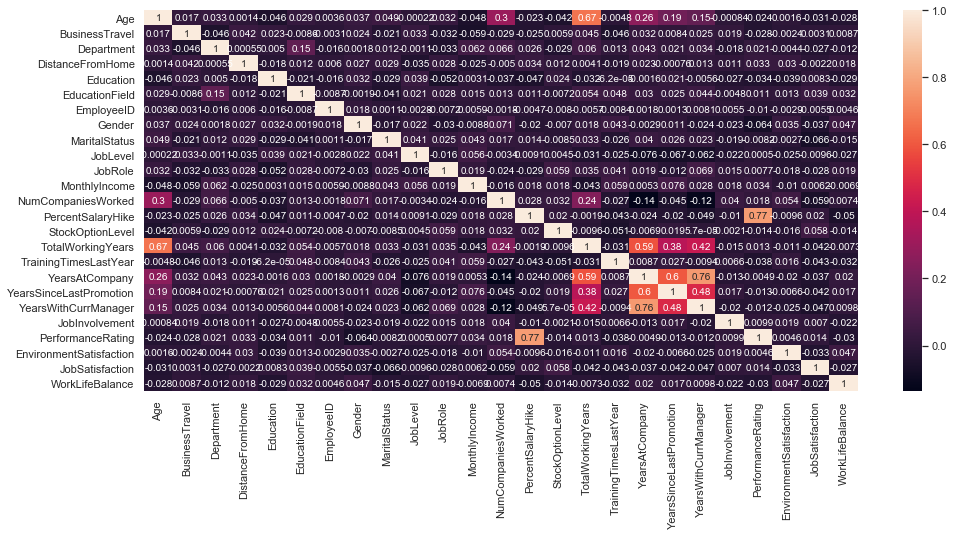

In [91]:
corr_cols = combinedStayNum[['Age','BusinessTravel','Department','DistanceFromHome',
                     'Education','EducationField','EmployeeID', 'Gender', 'MaritalStatus',
                      'JobLevel',
                     'JobRole','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                     'StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
                     'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager',
                     'JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                     'JobSatisfaction','WorkLifeBalance']]
corr = corr_cols.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr, annot=True)
plt.show()

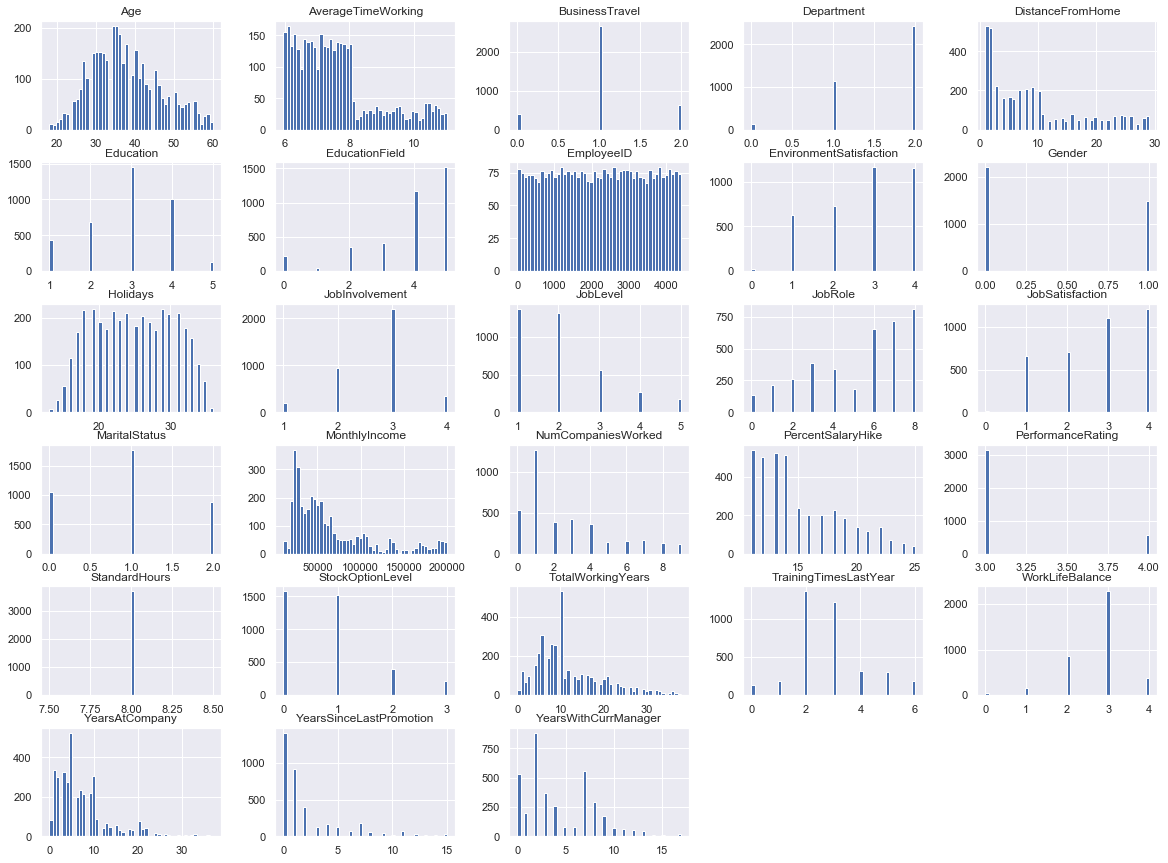

In [92]:
combinedStayNum.hist(bins=50, figsize=(20,15))
plt.show()

# Forêt d'arbres décisionnels

Nous allons tester de réaliser le modèle des forêts d'arbres décisionnels pour notre cas d'étude

On créer un dataframe à part pour faire nos test et ne pas modifier celui de base en retirant les différents columns que nous avons déclaré utinule:

In [93]:
dataSetForest = combined_csv.copy()
dataSetForest = dataSetForest.drop(columns=['Gender','MaritalStatus','JobRole','Department',
                                      'EducationField','BusinessTravel','EmployeeID'])
dataSetForest

,Age,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,6,2,1,131160,1.0,11,8,0,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,31,Yes,10,1,1,41890,0.0,23,8,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
2,32,No,17,4,4,193280,1.0,15,8,3,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,No,2,5,3,83210,3.0,11,8,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,No,10,1,1,23420,4.0,12,8,2,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,5,4,1,60290,3.0,17,8,1,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
4406,29,No,2,4,1,26790,2.0,15,8,0,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
4407,25,No,25,2,2,37020,0.0,20,8,0,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
4408,42,No,18,2,1,23980,0.0,14,8,1,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


In [95]:
for i in range (0, dataSetForest.shape[0]):
    if dataSetForest['Attrition'][i] == 'Yes':
        dataSetForest['Attrition'][i] = 0
    elif dataSetForest['Attrition'][i] == 'No':
        dataSetForest['Attrition'][i] = 1
        
dataSetForest['Attrition']=pd.to_numeric(dataSetForest['Attrition'])
dataSetForest

,Age,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,1,6,2,1,131160,1.0,11,8,0,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,31,0,10,1,1,41890,0.0,23,8,1,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
2,32,1,17,4,4,193280,1.0,15,8,3,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,1,2,5,3,83210,3.0,11,8,3,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,1,10,1,1,23420,4.0,12,8,2,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,1,5,4,1,60290,3.0,17,8,1,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
4406,29,1,2,4,1,26790,2.0,15,8,0,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
4407,25,1,25,2,2,37020,0.0,20,8,0,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
4408,42,1,18,2,1,23980,0.0,14,8,1,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


Nous allons maintenant créer un DataSet d'entrainement pour notre algorithme:

In [96]:
y = dataSetForest.Attrition
x = dataSetForest.drop('Attrition',axis=1)

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2)
x_train.head()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
4011,29,1,2,3,26780,1.0,25,8,1,1.0,...,1,0,0,3,4,4.0,2.0,3.0,8.013333,22
2157,50,20,2,5,154020,4.0,21,8,0,25.0,...,3,1,2,2,4,4.0,1.0,3.0,10.441111,23
2436,26,9,1,1,106860,1.0,14,8,1,3.0,...,3,0,2,3,3,4.0,3.0,4.0,7.681667,18
3737,34,2,4,2,68770,7.0,20,8,0,16.0,...,14,6,9,3,4,2.0,1.0,2.0,6.355278,35
342,32,3,1,2,171810,1.0,14,8,0,14.0,...,14,6,8,2,3,3.0,3.0,3.0,7.992778,30


In [99]:

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Testons d'abord avec un arbre unique avant de réaliser la forêt:

In [100]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

On fait calcule la rmse pour savoir l'écart type:

In [101]:
from sklearn.metrics import mean_squared_error
work_predictions = tree_reg.predict(x_train)
tree_mse = mean_squared_error(y_train, work_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

On tombe sur un cas de surapprentissage. On va donc passer par une validation croisé pour éviter le cas de surapprenstissage. 

In [102]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [103]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.15967389 0.15054199 0.22581298 0.21945077 0.16831106 0.21289852
 0.15054199 0.18437553 0.19217653 0.14101902]
Mean: 0.18048022564467928
Standard deviation: 0.029508405465570254


On peut voir que nous avons un bon résultat, testons maintenant avec la forêt (n_estimators étant le nombre d'arbre dans notre forêt) :

In [104]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor( n_estimators=10, random_state=0)
forest_reg.fit(x_train, y_train)

work_predictions = forest_reg.predict(x_train)
forest_mse = mean_squared_error(y_train, work_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.07523583480630934

In [105]:
forest_scores = cross_val_score(forest_reg, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.17978583 0.16831106 0.1865901  0.17899626 0.1586951  0.18907858
 0.18275512 0.17700691 0.17081023 0.15865199]
Mean: 0.17506811767707225
Standard deviation: 0.010153507629073898


On peut voir que c'est légèrement mieux. On teste la précision. Ici : precision correspond au rapport de "vrai positifs" sur le total de positifs, et recall correpond au rapport de "vrai positifs" sur le nombre total d'éléments. Le f1-score est calculé à partir de ces deux valeurs 

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = forest_reg.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Grâce à la réponse de cet internaute : https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target.
On a pu déterminer que non la raison pour laquelle la précision ou le recall n'était pas possible n'est pas un problème de données mais simplement que ce modèle n'est pas adapté pour notre cas d'études.
En effet nous tentons de comparer des données binaires (si l'employé a oui ou non quitté l'entreprise) et des données différentes comme le nombre d'heures qu'il travaille en moyenne. Ce n'est pas étonnant que le problèmes soit computationnel.
